# Setting up SFINCS to work with the National Water Model (Redelivery)
### Author: Tadd Bindas

In the below notebook, we will outline how SFINCS is to be set up to run on a prototype catchment (Coffeyville, KS) using NWM 3.1 inputs for discharge and output boundary levels

This notebook's outputs are meant to be fed into `02_post_process.ipynb` sequentially

### Imports and references to s3 bucket data

We're going to set up all of the imports to our required data and the data catalogs HydroMT uses to read data from cloud storage

In [50]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import teehr

from hydromt_sfincs import SfincsModel

In [51]:
data_catalog_path = Path.cwd().parent / "data/SFINCS/data_catalogs"
sfincs_model_path = Path.cwd().parent / "data/SFINCS/ngwpc_data"
lynker_spatial_lib = str(data_catalog_path / "lynker_spatial/gridded_data.yaml")
sf = SfincsModel(data_libs=[lynker_spatial_lib], root=str(sfincs_model_path), mode="w+")

In [52]:
import sys

current_dir = Path.cwd()
src_path = current_dir.parents[0]
sys.path.append(src_path.__str__())

from src.rise.utils import hydrofabric  # noqa: E402

In [53]:
file_path = Path("/Users/taddbindas/projects/fim-tools/data/conus_nextgen.gpkg")

flowlines = hydrofabric.get_layer(file_path, layer="flowpaths")
nexus = hydrofabric.get_layer(file_path, layer="nexus")
divides = hydrofabric.get_layer(file_path, layer="divides")
network = hydrofabric.get_layer(file_path, layer="network")
flowpath_attributes = hydrofabric.get_layer(file_path, layer="flowpath-attributes")

G = hydrofabric.get_hydrofabric_vpu_graph(nexus, flowlines)

KeyboardInterrupt: 

In [ ]:
# Hardcoded start and end nodes
start_node = "nex-2185393"
end_node = "nex-2185398" 
path = nx.shortest_path(G, start_node, end_node)
path

['nex-2185393',
 'wb-2185393',
 'nex-2185394',
 'wb-2185394',
 'nex-2185395',
 'wb-2185395',
 'nex-2185396',
 'wb-2185396',
 'nex-2185397',
 'wb-2185397',
 'nex-2185398']

In [ ]:
mask_flowlines = flowlines["id"].isin(path) | flowlines["toid"].isin(path) & (flowlines["toid"] != end_node)
mask_nexus = nexus["id"].isin(path) & (nexus["id"] != end_node)
mask_divides = divides["id"].isin(path)
mask_attributes = flowpath_attributes["id"].isin(path)

_subset_nexus = nexus[mask_nexus]
_subset_nexus = nexus[mask_nexus]
_subset_flowlines = flowlines[mask_flowlines]
_subset_divides = divides[mask_divides]
# buffered_divides = _subset_divides.buffer(500) # buffering divides by 500m

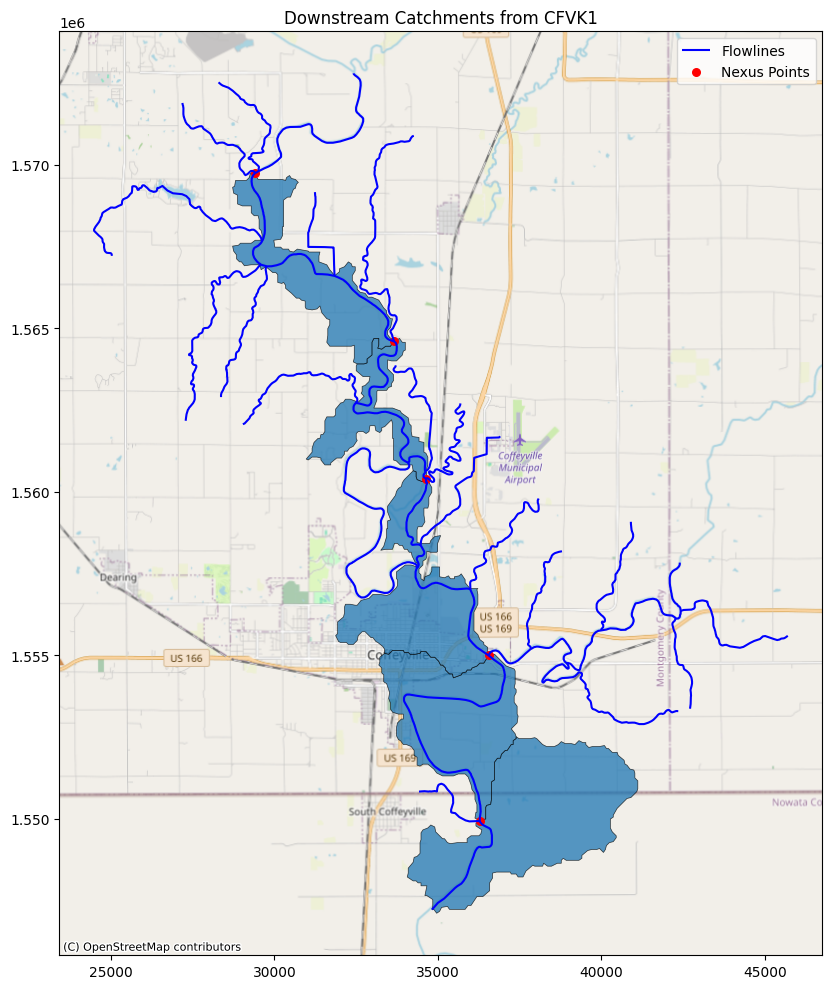

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
_subset_divides.plot(ax=ax, edgecolor="k", linewidth=0.5, alpha=0.75,)
# _subset_divides.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=1)  # Plot original divides
_subset_flowlines.plot(ax=ax, color='blue', label='Flowlines')
_subset_nexus.plot(ax=ax, color='red', markersize=30, label='Nexus Points')
try:
    cx.add_basemap(ax, crs=_subset_divides.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"Couldn't add basemap: {e}")
ax.legend()
plt.title("Downstream Catchments from CFVK1")
plt.tight_layout()
plt.show()

### Setting up the grid and the model inputs

Below, we're going to set up the following inputs:
- The grid
- Elevation
- Boundary mask
- Inputs
- Boundary forcings

In [ ]:
sf.setup_grid_from_region(
    region = {'geom': _subset_divides},
    res= 50,
    rotated=True,
    crs=_subset_divides.crs  # NAD83 / Conus Albers HARDCODED TODO figure out making this cleaner
)
# the input file is automatically updated. Uncomment to displayed below:
print(sf.config)

{'mmax': 152, 'nmax': 469, 'dx': 50, 'dy': 50, 'x0': 34478.0, 'y0': 1546832.0, 'rotation': 16.53, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 1, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070}


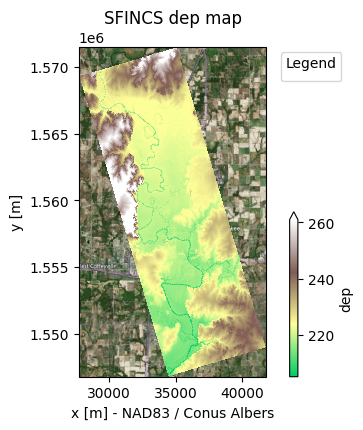

In [ ]:
datasets_dep = [{"elevtn": "USGS_seamless_13", "zmin": 0.001}]
dep = sf.setup_dep(datasets_dep=datasets_dep)
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)

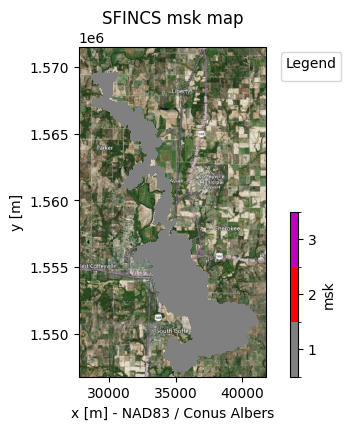

In [ ]:
sf.setup_mask_active(include_mask=_subset_divides,reset_mask=True)
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)


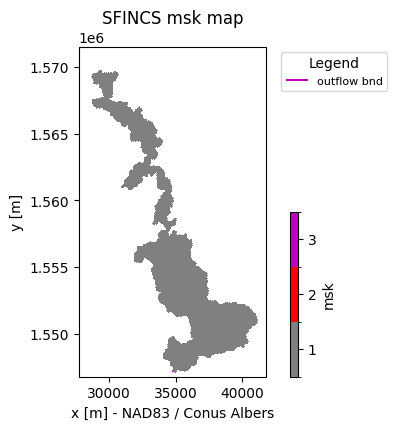

In [ ]:
_outflow_nexus = nexus[nexus["id"] == end_node]
sf.setup_mask_bounds(btype="outflow", include_mask=_outflow_nexus, reset_bounds=True)
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, zoomlevel=12)

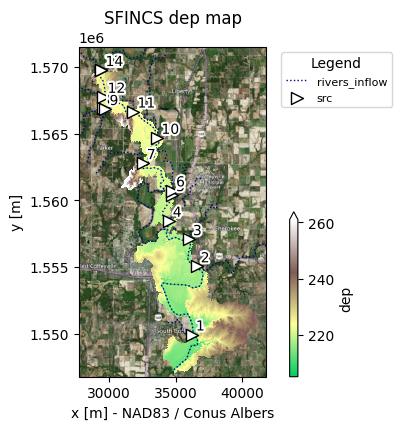

In [ ]:
sf.setup_river_inflow(
    rivers=_subset_flowlines, 
    buffer=10,
    keep_rivers_geom=True
)
# print(sf.config)
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)

In [ ]:
subset_attributes = flowpath_attributes[flowpath_attributes["id"].isin(sf.geoms["rivers_inflow"]["id"])]

In [ ]:
gdf_riv = sf.geoms["rivers_inflow"].copy()
df_reordered = pd.merge(gdf_riv["id"], subset_attributes, on='id', how='left')
gdf_riv["rivwth"] = np.mean(df_reordered["TopWdth"].values) # width [m]

# Assuming depth is 1.5m, TODO come back later
gdf_riv["rivdph"] = 1.5  # depth [m]
gdf_riv["manning"] = df_reordered["n"].tolist()  # manning coefficient [s.m-1/3]
gdf_riv[["geometry", "rivwth", "manning"]]

datasets_riv = [{"centerlines": gdf_riv}]

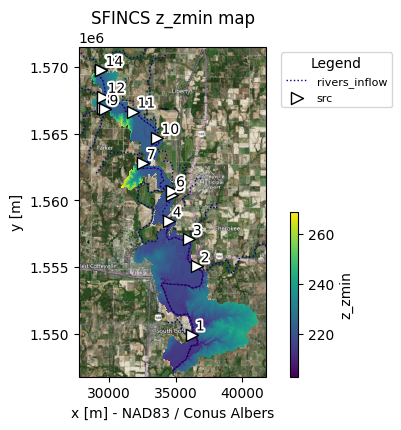

In [ ]:
sf.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=5,
    write_dep_tif=False,
    write_man_tif=False,
)
_ = sf.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
)

In [ ]:
subset_network = network[network["id"].isin(gdf_riv["id"])]
subset_network.groupby("id")["hf_id"]

In [ ]:
import teehr.fetching.nwm.retrospective_points as nwm_retro
START_DATE = datetime(2019, 5, 20)
END_DATE = datetime(2019, 5, 29)
nwm_retro.nwm_retro_to_parquet(
    nwm_version="nwm20",
    variable_name="streamflow",
    start_date=START_DATE,
    end_date=END_DATE,
    location_ids=[7086109, 7040481],
    output_parquet_dir=Path(Path.home(), "nwm20_retrospective")
)


KeyboardInterrupt: 